# ARMseq Pipeline

Getting ARMseq pipeline to work. Yeast data.

Note: not all commands can be excuted from this script. See commented sections

In [177]:
.libPaths("~/R/x86_64-redhat-linux-gnu-library/3.2/")
options(repr.plot.width = 6)
options(repr.plot.height = 5)
options(jupyter.plot_mimetypes = 'image/png')

In [3]:
library(dplyr)
library(rtracklayer)
library(ggplot2)
library(Rsamtools)
library(Biostrings)
library(seqinr)

In [4]:
genome = read.fasta("/g/steinmetz/genome/Saccharomyces_cerevisiae/S288c_ERCC/ver_20150412/fasta/S288c_complete_wERCC.fsa")

In [5]:
setwd("/g/steinmetz/project/IESY/trna/ARMseq/")

First you must download ARMseq datasets with . [This](processANDalign.txt) bash script does these steps.

In [7]:
# load annotation gtf
gtf_annotations = read.delim("../ARMseq/data/SGD_features.tab", sep="\t", header = F)
colnames(gtf_annotations) = c("ID", "Type", "Confidence", "Sys.Name", 
                          "Common.Name", "Alt.Name", "Location", "Alt.ID", "Chr",
                         "Start", "Stop", "Strand", "Unknown.Loc", "Date.1", "Date.2", "Description")
gtf_tRNAs = gtf_annotations %>% filter(Type == "tRNA_gene") %>% select(Type, Sys.Name, Common.Name, Alt.Name, 
                                                               Chr, Start, Stop, Strand, Description)


Warning message:
In scan(file, what, nmax, sep, dec, quote, skip, nlines, na.strings, : EOF within quoted string

In [383]:
window = 50

tRNA_annotations = read.delim(
    "../ARMseq/data/tRNA_isoforms_wleaders_4R.txt", sep = "\t", header = T, strip.white=TRUE)
# switch start / end when end < start. denote strand instead
tRNA_annotations = data.frame(do.call(rbind, apply(tRNA_annotations, 1, function(i){
    #print(i["Start"])
    if (i["Chr"] == "chrM") {
        i["Chr"] = "chrMT"
    }
    if (as.numeric(i["Start"]) < as.numeric(i["End"])) {
        o = i
        # modify upstream/downstream sequences based on window of interest
        o$Upstream = paste(genome[[i["Chr"]]][seq((as.numeric(i["Start"]) - window),
                                                          (as.numeric(i["Start"]) - 1))], collapse = "")
        o$Downstream = paste(genome[[i["Chr"]]][seq((as.numeric(i["End"]) + 1),
                                                          (as.numeric(i["End"]) + window))], collapse = "")
        o$Start = as.numeric(i["Start"])
        o$End = as.numeric(i["End"])
        o$Strand = "+"
    } else {
        o = i
        # modify upstream/downstream sequences based on window of interest
        o$Upstream = tolower(as.character(reverseComplement(DNAString(paste(genome[[i["Chr"]]][seq((as.numeric(i["Start"]) + 1),
                                                          (as.numeric(i["Start"]) + window))], collapse = "")))))
        o$Downstream = tolower(as.character(reverseComplement(DNAString(paste(genome[[i["Chr"]]][seq((as.numeric(i["End"]) - window),
                                                          (as.numeric(i["End"]) - 1))], collapse = "")))))
        o$Start = as.numeric(i["End"])
        o$End = as.numeric(i["Start"])
        o$Strand = "-"
    }
    return(o)
})))
tRNA_annotations$Start = as.numeric(tRNA_annotations$Start)
tRNA_annotations$End = as.numeric(tRNA_annotations$End)
tRNA_annotations$End = as.numeric(tRNA_annotations$End)
tRNA_annotations$tRNA.Number = as.numeric(tRNA_annotations$tRNA.Number)
tRNA_annotations$tRNA.type = as.character(tRNA_annotations$tRNA.type)




In [385]:
head(tRNA_annotations)

,Chr,tRNA.Number,Start,End,tRNA.type,Anticodon,Upstream,Downstream,Intron.Start,Intron.End,Cove,HMM,X2pStr,Hit.Origin,Strand
1,chrIV,3,410379,410451,Ala,AGC,ttaagtgcaaacatgtaagaaagattctcggtaacgaccatacaaatatt,aattattttttactttccgcggtgccgagatgcagacgtggccaactgtg,0,0,74.48,50.69,23.79,Bo,+
2,chrVI,6,204924,204996,Ala,AGC,tgtaaagtaaacctgtatcatttctgtttggaagatttcaacaaacgttc,tttaaatttttttattttttttgtcaaatctctctatctatagagataat,0,0,74.48,50.69,23.79,Bo,-
3,chrVII,15,774349,774421,Ala,AGC,ttagatttacttcattattcttctctattctcccctttcatcaattaatt,aatttttttacttttaatgaggtatactggaatattacggctcttttttt,0,0,74.48,50.69,23.79,Bo,+
4,chrVIII,8,146242,146314,Ala,AGC,acactccggtattactcgagcccgtaatacaacacattcaacaaatatca,atcttttttgttattaccataacagtactataaaggtctgttaatgtata,0,0,74.48,50.69,23.79,Bo,-
5,chrX,22,197313,197385,Ala,AGC,tgtcatactgacgtatctcactttgataaacaacaatatcaataatatta,atttctttttgttctcaacgacaataataagaaaatcaacttaaatggaa,0,0,74.48,50.69,23.79,Bo,-
6,chrXI,4,219895,219967,Ala,AGC,taaaagagcttgttatagtaatctaagtggaaatacactaacagtaaata,atctttttatacttattaataatttttttcctgccgttacttgcttttaa,0,0,74.48,50.69,23.79,Bo,+


In [386]:
gr <- GRanges(seqnames = Rle(unlist(tRNA_annotations$Chr)), 
             ranges = IRanges(start = tRNA_annotations$Start-window,
                             end = tRNA_annotations$End+window),
             strand = Rle(unlist(tRNA_annotations$Strand)),
             mcols = select(tRNA_annotations, tRNA.Number,tRNA.type, Upstream, Downstream))

In [387]:
gr_list = RangesList(lapply(seq(1,length(gr)),function(i){ranges(gr[i,])}))
names(gr_list) = seqnames(gr)

In [388]:
what = c("qname", "flag", "rname", "strand", "pos", "mapq", "cigar", "seq", "qual")

In [389]:
param = ScanBamParam(which = gr_list, what = what)

In [390]:
fdir = "/g/steinmetz/project/IESY/trna/ARMseq/data/"
bam <- scanBam(paste0(fdir,"untreated.bam"), param=param, 
               index = paste0(fdir,"untreated.bam.bai"))

Warning message:
In `levels<-`(`*tmp*`, value = if (nl == nL) as.character(labels) else paste0(labels, : duplicated levels in factors are deprecatedWarning message:
In `levels<-`(`*tmp*`, value = if (nl == nL) as.character(labels) else paste0(labels, : duplicated levels in factors are deprecatedWarning message:
In `levels<-`(`*tmp*`, value = if (nl == nL) as.character(labels) else paste0(labels, : duplicated levels in factors are deprecatedWarning message:
In `levels<-`(`*tmp*`, value = if (nl == nL) as.character(labels) else paste0(labels, : duplicated levels in factors are deprecated

In [391]:
# combine bam and tRNA infos
happy_bam = do.call(rbind, lapply(bam, function(x){
    x$seq = as.character(x$seq)
    x$qual = as.character(x$qual)
    o = data.frame(x)
    return(o)
    }))
happy_bam$Chr = sapply(rownames(happy_bam), function(x) strsplit(x, ":")[[1]][1])
happy_bam$Start = sapply(rownames(happy_bam), function(x) {
    x = strsplit(x, ":")[[1]][2]
    x = as.numeric(strsplit(x, "-")[[1]][1]) + window
    })
happy_bam$End = sapply(rownames(happy_bam), function(x) {
    x = strsplit(x, ":")[[1]][2]
    x = strsplit(x, "-")[[1]][2]
    x = as.numeric(strsplit(x, "\\.")[[1]][1]) - window
    })

In [392]:
# quick check of distribution of all mapping points to the tRNA locus
distance_dist = apply(cbind(abs(happy_bam$pos - happy_bam$Start), 
                            abs(happy_bam$pos - happy_bam$end)),1,min)

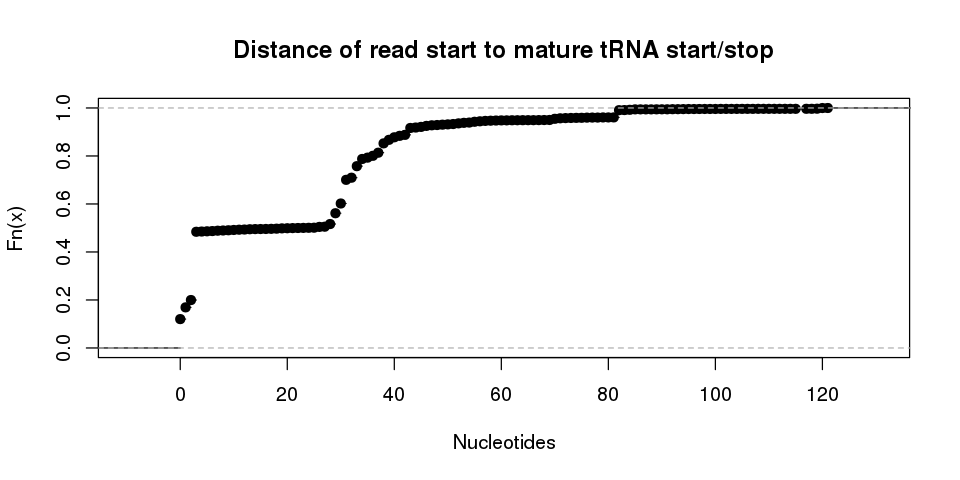

In [393]:
options(repr.plot.width = 8)
options(repr.plot.height = 4)
plot(ecdf(distance_dist), main = "Distance of read start to mature tRNA start/stop", 
     xlab = "Nucleotides")

In [394]:
# all isoacceptors
this_anticodon = tRNA_annotations$Anticodon[1]
anticodon_tRNAs = filter(tRNA_annotations, Anticodon %in% this_anticodon)
anticodon_bams = bam[anticodon_names]
# collpase reads
# first convert 
anticodon_bams = lapply(anticodon_bams, function(x){
    x$seq = as.character(x$seq)
    x$qual = as.character(x$qual)
    o = data.frame(x)
    return(o)
    })
readsXisoform = "X"
# tRNA
this_tRNA = 1
# Read
this_read = 1

#seqlen = abs(tRNA_annotations$Start[i]-bam[[i]]$pos[j])
#s1 = bam[[i]]$seq[[j]][1:seqlen]
#s2 = DNAString(tRNA_annotations[1,"Upstream"])

In [395]:
colnames(anticodon_tRNAs)
colnames(happy_bam)

[1] "Chr"          "tRNA.Number"  "Start"        "End"          "tRNA.type"   
 [6] "Anticodon"    "Upstream"     "Downstream"   "Intron.Start" "Intron.End"  
[11] "Cove"         "HMM"          "X2pStr"       "Hit.Origin"   "Strand"

[1] "qname"  "flag"   "rname"  "strand" "pos"    "mapq"   "cigar"  "seq"   
 [9] "qual"   "Chr"    "Start"  "End"

In [398]:
tmp = merge(anticodon_tRNAs, happy_bam, by = c("Chr","Start","End"))

In [399]:
head(tmp)

,Chr,Start,End,tRNA.Number,tRNA.type,Anticodon,Upstream,Downstream,Intron.Start,Intron.End,Cove,HMM,X2pStr,Hit.Origin,Strand,qname,flag,rname,strand,pos,mapq,cigar,seq,qual
1,chrIV,410379,410451,3,Ala,AGC,ttaagtgcaaacatgtaagaaagattctcggtaacgaccatacaaatatt,aattattttttactttccgcggtgccgagatgcagacgtggccaactgtg,0,0,74.48,50.69,23.79,Bo,+,SRR1874045.553080,256,chrIV,+,410416,1,34M,TGGGAGAGGTCTCCGGTTCGATTCCGGACTCGTC,BCCCCCCBCFFFGGGGGGGGGGHHHHGGGGHGFG
2,chrIV,410379,410451,3,Ala,AGC,ttaagtgcaaacatgtaagaaagattctcggtaacgaccatacaaatatt,aattattttttactttccgcggtgccgagatgcagacgtggccaactgtg,0,0,74.48,50.69,23.79,Bo,+,SRR1874045.623350,256,chrIV,+,410416,1,34M,TGGGAGAGGTCTCCGGTTCGATTCCGGACTCGTC,DDDDDDCCCFFFGGGGGGGGGGHHHHGGGGHGHG
3,chrIV,410379,410451,3,Ala,AGC,ttaagtgcaaacatgtaagaaagattctcggtaacgaccatacaaatatt,aattattttttactttccgcggtgccgagatgcagacgtggccaactgtg,0,0,74.48,50.69,23.79,Bo,+,SRR1874045.717897,256,chrIV,+,410416,1,34M,TGGGAGAGGTCTCCGGTTCGATTCCGGACTCGTC,AAAAAAAAA@FFGGGGGGGGCGHHHHGGGGHGGG
4,chrIV,410379,410451,3,Ala,AGC,ttaagtgcaaacatgtaagaaagattctcggtaacgaccatacaaatatt,aattattttttactttccgcggtgccgagatgcagacgtggccaactgtg,0,0,74.48,50.69,23.79,Bo,+,SRR1874045.831740,256,chrIV,+,410416,1,35M,TGGGAGAGGTCTCCGGTTCGATTCCGGACTCGTCC,BAABBBBBBCCFFGGGGEFGGGGHHF2EEFHGHGG
5,chrIV,410379,410451,3,Ala,AGC,ttaagtgcaaacatgtaagaaagattctcggtaacgaccatacaaatatt,aattattttttactttccgcggtgccgagatgcagacgtggccaactgtg,0,0,74.48,50.69,23.79,Bo,+,SRR1874045.860443,256,chrIV,+,410416,1,34M,TGGGAGAGGTCTCCGGTTCGATTCCGGACTCGTC,BBBBBBBBBFFFGGGFFGFGEGFFDGFGGGHGAE
6,chrIV,410379,410451,3,Ala,AGC,ttaagtgcaaacatgtaagaaagattctcggtaacgaccatacaaatatt,aattattttttactttccgcggtgccgagatgcagacgtggccaactgtg,0,0,74.48,50.69,23.79,Bo,+,SRR1874045.928061,0,chrIV,+,410416,1,34M,TGGGAGAGGTCTCCGGTTCGATTCCGGACTCGTC,BAABBAAABFFFGCEGGGGECGCHG4EDGGGGHG


In [366]:
PhredQuality(as.character(tmp$qual[1]))

  A PhredQuality instance of length 1
    width seq
[1]    34 BCCCCCCBCFFFGGGGGGGGGGHHHHGGGGHGFG

In [422]:
head(tmp2)

,Chr,Start,End,tRNA.Number,tRNA.type,Anticodon,Upstream,Downstream,Intron.Start,Intron.End,Cove,HMM,X2pStr,Hit.Origin,Strand,qname,flag,rname,strand,pos,mapq,cigar,seq,qual
1,chrVI,204924,204996,6,Ala,AGC,tgtaaagtaaacctgtatcatttctgtttggaagatttcaacaaacgttc,tttaaatttttttattttttttgtcaaatctctctatctatagagataat,0,0,74.48,50.69,23.79,Bo,-,SRR1874045.494891,272,chrVI,-,204909,38,12M2I29M,AAAAAGAAATTTTAAAATGGACGAGTCCGGAATCGAACCGGAG,HHHHHHHHHHHHHHHHHGGGHGGGGGGGGGGFBBBAABBBBBB
2,chrX,197313,197385,22,Ala,AGC,tgtcatactgacgtatctcactttgataaacaacaatatcaataatatta,atttctttttgttctcaacgacaataataagaaaatcaacttaaatggaa,0,0,74.48,50.69,23.79,Bo,-,SRR1874045.494891,272,chrX,-,197303,38,10M7I26M,AAAAAGAAATTTTAAAATGGACGAGTCCGGAATCGAACCGGAG,HHHHHHHHHHHHHHHHHGGGHGGGGGGGGGGFBBBAABBBBBB
3,chrXI,517988,518060,9,Ala,AGC,gtaaaaatatatgatccaattcctaggacatcagaaaatatatctactat,ttttaaaatttctttttttttttttctctttccgtatgtaagcttttttc,0,0,74.48,50.69,23.79,Bo,+,SRR1874045.494891,0,chrXI,+,518035,38,43M,CTCCGGTTCGATTCCGGACTCGTCCATTTTAAAATTTCTTTTT,BBBBBBAABBBFGGGGGGGGGGHGGGHHHHHHHHHHHHHHHHH
4,chrXIII,321147,321219,17,Ala,AGC,tatcctacatttatgttttctatacttcttcaaagtcttcaatacaaatc,ttttttatttttttggctaactaacccatatataacgtcttttacgaggt,0,0,74.48,50.69,23.79,Bo,-,SRR1874045.494891,272,chrXIII,-,321135,38,8M5I30M,AAAAAGAAATTTTAAAATGGACGAGTCCGGAATCGAACCGGAG,HHHHHHHHHHHHHHHHHGGGHGGGGGGGGGGFBBBAABBBBBB
5,chrXVI,856902,856974,7,Ala,AGC,acactccggtattactcgagcccgtaatacaacaatttacaacaagattc,ttttaatttttgattatggaatacaaaatgtatatttcgtataaaattat,0,0,74.48,50.69,23.79,Bo,+,SRR1874045.494891,256,chrXVI,+,856949,38,32M6I5M,CTCCGGTTCGATTCCGGACTCGTCCATTTTAAAATTTCTTTTT,BBBBBBAABBBFGGGGGGGGGGHGGGHHHHHHHHHHHHHHHHH


In [440]:
filter(tmp, qname == "SRR1874045.494891")[3,]


,Chr,Start,End,tRNA.Number,tRNA.type,Anticodon,Upstream,Downstream,Intron.Start,Intron.End,Cove,HMM,X2pStr,Hit.Origin,Strand,qname,flag,rname,strand,pos,mapq,cigar,seq,qual
3,chrXI,517988,518060,9,Ala,AGC,gtaaaaatatatgatccaattcctaggacatcagaaaatatatctactat,ttttaaaatttctttttttttttttctctttccgtatgtaagcttttttc,0,0,74.48,50.69,23.79,Bo,+,SRR1874045.494891,0,chrXI,+,518035,38,43M,CTCCGGTTCGATTCCGGACTCGTCCATTTTAAAATTTCTTTTT,BBBBBBAABBBFGGGGGGGGGGHGGGHHHHHHHHHHHHHHHHH


In [458]:
subseq(as.character(x$seq[[1]]),1,5)

[1] "CTCCG"

In [496]:
filter(tmp, qname == "SRR1874045.494891")

,Chr,Start,End,tRNA.Number,tRNA.type,Anticodon,Upstream,Downstream,Intron.Start,Intron.End,Cove,HMM,X2pStr,Hit.Origin,Strand,qname,flag,rname,strand,pos,mapq,cigar,seq,qual
1,chrVI,204924,204996,6,Ala,AGC,tgtaaagtaaacctgtatcatttctgtttggaagatttcaacaaacgttc,tttaaatttttttattttttttgtcaaatctctctatctatagagataat,0,0,74.48,50.69,23.79,Bo,-,SRR1874045.494891,272,chrVI,-,204909,38,12M2I29M,AAAAAGAAATTTTAAAATGGACGAGTCCGGAATCGAACCGGAG,HHHHHHHHHHHHHHHHHGGGHGGGGGGGGGGFBBBAABBBBBB
2,chrX,197313,197385,22,Ala,AGC,tgtcatactgacgtatctcactttgataaacaacaatatcaataatatta,atttctttttgttctcaacgacaataataagaaaatcaacttaaatggaa,0,0,74.48,50.69,23.79,Bo,-,SRR1874045.494891,272,chrX,-,197303,38,10M7I26M,AAAAAGAAATTTTAAAATGGACGAGTCCGGAATCGAACCGGAG,HHHHHHHHHHHHHHHHHGGGHGGGGGGGGGGFBBBAABBBBBB
3,chrXI,517988,518060,9,Ala,AGC,gtaaaaatatatgatccaattcctaggacatcagaaaatatatctactat,ttttaaaatttctttttttttttttctctttccgtatgtaagcttttttc,0,0,74.48,50.69,23.79,Bo,+,SRR1874045.494891,0,chrXI,+,518035,38,43M,CTCCGGTTCGATTCCGGACTCGTCCATTTTAAAATTTCTTTTT,BBBBBBAABBBFGGGGGGGGGGHGGGHHHHHHHHHHHHHHHHH
4,chrXIII,321147,321219,17,Ala,AGC,tatcctacatttatgttttctatacttcttcaaagtcttcaatacaaatc,ttttttatttttttggctaactaacccatatataacgtcttttacgaggt,0,0,74.48,50.69,23.79,Bo,-,SRR1874045.494891,272,chrXIII,-,321135,38,8M5I30M,AAAAAGAAATTTTAAAATGGACGAGTCCGGAATCGAACCGGAG,HHHHHHHHHHHHHHHHHGGGHGGGGGGGGGGFBBBAABBBBBB
5,chrXVI,856902,856974,7,Ala,AGC,acactccggtattactcgagcccgtaatacaacaatttacaacaagattc,ttttaatttttgattatggaatacaaaatgtatatttcgtataaaattat,0,0,74.48,50.69,23.79,Bo,+,SRR1874045.494891,256,chrXVI,+,856949,38,32M6I5M,CTCCGGTTCGATTCCGGACTCGTCCATTTTAAAATTTCTTTTT,BBBBBBAABBBFGGGGGGGGGGHGGGHHHHHHHHHHHHHHHHH


In [602]:
remapRead = function(x) {
    #print(x)
    tRNA_strand = x$Strand
    read_strand = x$strand
    seq = as.character(x$seq)
    quality = as.character(x$qual)
    upstream = x$Upstream[[1]]
    downstream = x$Downstream[[1]]
    # do tRNA strand and mapped read strand agree?
    if (tRNA_strand != read_strand) {
        cat("tRNA and read strand do not agree")
    }
    #print(read_strand)
    if ((tRNA_strand == "+") && (read_strand == "+")) {
        # easy case
        # is read start closer to upstream or downstream region
        if (x$pos > x$Start) {
            d_name = "End"
        } else {
            d_name = "Start"
        }
        #print(d_name)
        if (d_name == "End") {
            # read should be aligned to downstream region
            # take only end region of read for alignment
            read_subseq = subseq(seq, abs(x$pos - x$End) + 2,nchar(seq))
            read_quality = subseq(quality, abs(x$pos - x$End) + 2,nchar(quality))
            pattern = DNAString(downstream)
            #print(seq)
            #print(DNAString(read_subseq))
            #print(pattern)

        } else if (d_name == "Start") {
            # read should be aligned to upstream region
            # take only start region of read for alignment
            read_subseq = subseq(seq, 1, abs(x$Start - x$pos))
            read_quality = subseq(quality, 1, abs(x$Start - x$pos))
            pattern = DNAString(upstream)
            #print(seq)
            #print(DNAString(read_subseq))
            #print(pattern)  
        }
    } else if ((tRNA_strand == "-") && (read_strand == "-")) {
        # is read start closer to upstream or downstream region
        # note orientation is reversed due to limitations in reading bam file with Ramtools
        if (x$pos < x$Start) {
            d_name = "End"
        } else {
            d_name = "Start"
        }
        #print(d_name)
        if (d_name == "End") {
            # read should be aligned to downstream region
            # take only end region of read for alignment
            read_subseq = as.character(reverseComplement(DNAString(subseq(seq, 1, abs(x$pos - x$Start)))))
            read_quality = reverse(subseq(quality, 1, abs(x$pos - x$Start)))
            pattern = DNAString(downstream)
            #print(seq)
            #print(DNAString(read_subseq))
            #print(pattern)

        } else if (d_name == "Start") {
            # read should be aligned to upstream region
            # take only start region of read for alignment
            read_subseq = as.character(reverseComplement(DNAString(subseq(seq, abs(x$pos - x$End) + 2, nchar(seq)))))
            read_quality = reverse(subseq(quality, abs(x$pos - x$End) + 2, nchar(seq)))
            pattern = DNAString(upstream)
            #print(seq)
            #print(DNAString(read_subseq))
            #print(pattern)  
        }
    }
    o = pairwiseAlignment(pattern = pattern, subject = DNAString(read_subseq),
                          subjectQuality = PhredQuality(read_quality),
                          gapOpening = 0, gapExtension = -5, type = "overlap", 
                          scoreOnly = T)
    return(o)
}

In [635]:
read = "SRR1874045.717800"
rs = lapply(seq(1:dim(filter(tmp, qname == read))[1]), function(i) {
    x = filter(tmp, qname == read)[i,]
    o = as.numeric(remapRead(x))
    names(o) = paste(x$Chr,x$Start,sep=":")
    return(o)
})


In [636]:
rs

[[1]]
chrIV:410379 
    7.962325 

[[2]]
chrVI:204924 
    1.990581 

[[3]]
chrVII:774349 
     21.89496 

[[4]]
chrVIII:146242 
      7.961181 

[[5]]
chrX:197313 
   9.904382 

[[6]]
chrXI:219895 
    1.990581 

[[7]]
chrXI:517988 
     3.98059 

[[8]]
chrXII:656934 
     1.990581 

[[9]]
chrXIII:321147 
      5.970885 

[[10]]
chrXIII:768369 
      3.981162 

[[11]]
chrXVI:856902 
    0.9708855

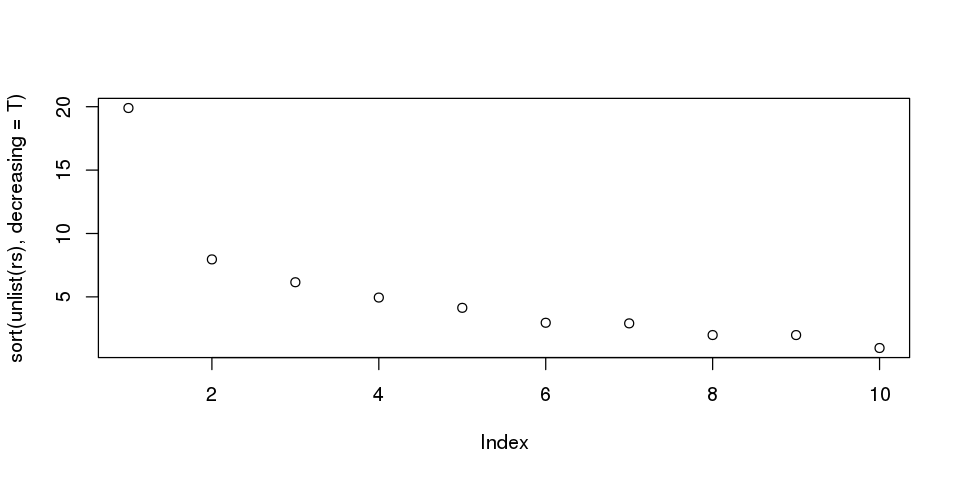

In [620]:
plot(sort(unlist(rs), decreasing = T))

In [275]:
reverseComplement(s2)

  43-letter "DNAString" instance
seq: CTCCGGTTCGATTCCGGACTCGTCCATTTTAAAATTTCTTTTT

In [59]:
score(globalAligns1s2)

ERROR: Error in UseMethod("score"): no applicable method for 'score' applied to an object of class "c('PairwiseAlignmentsSingleSubject', 'PairwiseAlignments')"
